In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.preprocessing import LabelEncoder

filepath_in = 'data/sample_data_for_task1.csv'

2024-03-12 20:32:20.284282: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Data and preprocess it

In [ ]:
df = pd.read_csv(filepath_in)
df.dropna(inplace=True)

label_encoder = LabelEncoder()

# We have imbalanced data so we sample the same amount from each class
df_list = []

for sub in df['label'].unique():
    df_temp = df[df['label'] == sub]
    for i in range(3):
        df_list.append(df_temp.sample(2500))

df_new = pd.concat(df_list)

X = df_new['text'].reset_index().drop(columns='index')
y = df_new['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [ ]:
# Save the Label Encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

### Vectorize the data

In [4]:
vectorizer = CountVectorizer()
tokenizer = vectorizer.build_tokenizer()
tokenized_text = X_train['text'].apply(tokenizer)

In [5]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [6]:
embedding_dim = 50 
window_size = 1
min_count = 2

word2vec_model = Word2Vec(
    sentences=tokenized_text, 
    vector_size=embedding_dim, 
    window=window_size, 
    min_count=min_count
)

word2vec_model.save('word2vec_model.bin')

In [7]:
def text_to_embeddings(text, word2vec_model=word2vec_model):
    tokens = tokenizer(text)
    embeddings = []
    for token in tokens:
        if token in word2vec_model.wv:
            embeddings.append(word2vec_model.wv[token])
    if embeddings:
        return np.mean(embeddings, axis=0)  # Average of word embeddings in the text
    else:
        return np.zeros(embedding_dim)  # If no embeddings found, return zero vectors

In [8]:
def embed_df(df_in):
    df = df_in.copy()
    df['embeddings'] = df['text'].apply(text_to_embeddings)
    col_list = [f'emb_{i}' for i in range(embedding_dim)]
    df[col_list] = pd.DataFrame(df['embeddings'].tolist(), index= df.index)
    df = df.drop(columns=['text', 'embeddings'])
    return df

X_train = embed_df(X_train)
X_test = embed_df(X_test)

### Create and Train Model

In [9]:
# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/100
900/900 [==============================] - 3s 2ms/step - loss: 1.5973 - accuracy: 0.3066 - val_loss: 1.5399 - val_accuracy: 0.3367
Epoch 2/100
900/900 [==============================] - 2s 2ms/step - loss: 1.5070 - accuracy: 0.3523 - val_loss: 1.4921 - val_accuracy: 0.3732
Epoch 3/100
900/900 [==============================] - 2s 2ms/step - loss: 1.4739 - accuracy: 0.3712 - val_loss: 1.4874 - val_accuracy: 0.3631
Epoch 4/100
900/900 [==============================] - 2s 2ms/step - loss: 1.4536 - accuracy: 0.3909 - val_loss: 1.4565 - val_accuracy: 0.3947
Epoch 5/100
900/900 [==============================] - 2s 2ms/step - loss: 1.4305 - accuracy: 0.4062 - val_loss: 1.4625 - val_accuracy: 0.3896
Epoch 6/100
900/900 [==============================] - 2s 2ms/step - loss: 1.4119 - accuracy: 0.4174 - val_loss: 1.4172 - val_accuracy: 0.4201
Epoch 7/100
900/900 [==============================] - 2s 2ms/step - loss: 1.3950 - accuracy: 0.4272 - val_loss: 1.3999 - val_accuracy: 0.4282

In [11]:
model.save('model.h5')

/Users/Philipp/opt/anaconda3/envs/projects/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


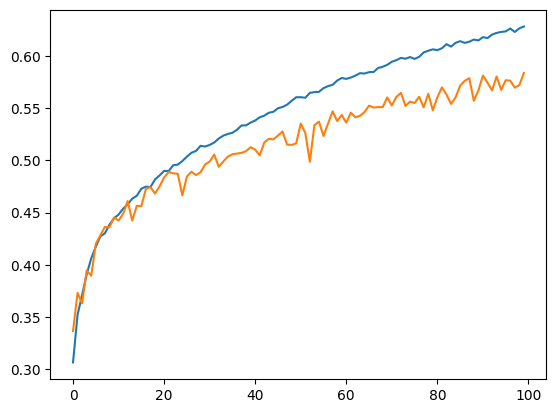

In [12]:
fig, ax = plt.subplots(1, 1)

sns.lineplot(
    history.history['accuracy'],
    ax=ax
)

sns.lineplot(
    history.history['val_accuracy'],
    ax=ax
)

plt.show()

### Test on some small data

In [13]:
tuple_test_data = (
    ('zucker fabrik', 'ft'),
    ('Lebensmittel kommssionierung', 'ft'),
    ('geländer biegen', 'mr'),
    ('gebäudeausrüstung technische', 'ct'),
    ('kürbiskernöl softgels', 'ft')
)

In [19]:
for sample in tuple_test_data:
    word = sample[0]
    correct = sample[1]
    new_word_embedding = text_to_embeddings(word).reshape(1, -1) 

    # Predict the label for the embedded word
    predicted_probabilities = model.predict(new_word_embedding)
    predicted_label_index = predicted_probabilities.argmax(axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_label_index])

    print(f'For word {word}')
    print(f'We predict {predicted_label[0]}')
    print(f'The correct solution is {correct}')
    print()

1/1 [==============================] - 0s 25ms/step
For word zucker fabrik
We predict ct
The correct solution is ft

1/1 [==============================] - 0s 24ms/step
For word Lebensmittel kommssionierung
We predict ft
The correct solution is ft

1/1 [==============================] - 0s 23ms/step
For word geländer biegen
We predict mr
The correct solution is mr

1/1 [==============================] - 0s 21ms/step
For word gebäudeausrüstung technische
We predict ch
The correct solution is ct

1/1 [==============================] - 0s 21ms/step
For word kürbiskernöl softgels
We predict ch
The correct solution is ft



In [17]:
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)